In [30]:
from pandas import HDFStore
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import json
import h5py
import os

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [22]:
class LeagueStats():
    
    def __init__(self, df):   
        self.df = df
        self.matches = 0
        self.draws = 0
        self.odd_goals = 0
        self.even_goals = 0
        self.zero_goals = 0
        self.one_goal = 0
        self.two_goals = 0
        self.three_goals = 0
        self.over0_5 = 0
        self.over1_5 = 0
        self.over2_5 = 0
        self.over3_5 = 0
        self.home_win = 0
        self.away_win = 0

    def update(self):
        self.matches = self.df.shape[0]
        self.draws = self.df[self.df['FTHG'] == self.df['FTAG']].shape[0]
        self.even_goals = self.df[(self.df['FTHG'] + self.df['FTAG']) % 2 == 0].shape[0]
        self.odd_goals = self.df[(self.df['FTHG'] + self.df['FTAG']) % 2 == 1].shape[0]
        self.zero_goals = self.df[(self.df['FTHG'] + self.df['FTAG']) == 0].shape[0]
        self.one_goal = self.df[(self.df['FTHG'] + self.df['FTAG']) == 1].shape[0]
        self.two_goals = self.df[(self.df['FTHG'] + self.df['FTAG']) == 2].shape[0]
        self.three_goals = self.df[(self.df['FTHG'] + self.df['FTAG']) == 3].shape[0]
        self.over0_5 = self.df[(self.df['FTHG'] + self.df['FTAG']) > 0.5].shape[0]
        self.over1_5 = self.df[(self.df['FTHG'] + self.df['FTAG']) > 1.5].shape[0]
        self.over2_5 = self.df[(self.df['FTHG'] + self.df['FTAG']) > 2.5].shape[0]
        self.over3_5 = self.df[(self.df['FTHG'] + self.df['FTAG']) > 3.5].shape[0]
        self.home_win = self.df[(self.df['FTHG'] > self.df['FTAG'])].shape[0]
        self.away_win = self.df[(self.df['FTHG'] < self.df['FTAG'])].shape[0]
        
    def get_probability(self, selection):
        return round(getattr(self, selection) / getattr(self, 'matches'), 3)

In [23]:
def load_folder_into_h5(h5_file_name, folder_path):
    
    '''
    Populate h5 database with all leagues stores as csv files in folder_path
    '''

    for subdir, dirs, files in os.walk(folder_path):
        for file in files:

            file_path = os.path.join(subdir, file)
            h5_path = file_path.replace(folder_path, '').replace('.csv', '')

            df = pd.read_csv(file_path, encoding = 'latin-1')
            df = df.iloc[:, 1:]
            df.dropna(axis = 0, inplace = True)

            try:
                h5 = h5py.File(h5_file_name, 'r+')
                h5.create_group(h5_path)
                h5.close()
            except :
                pass

            try:
                store = HDFStore(h5_file_name)
                store[h5_path] = df
                store.close()
            except :
                pass

In [24]:
def get_history_df(selection):
    
    history = {}

    for league in teams.keys():
        stats_list = []
        for key in h5.keys():      
            if league in key and '2017' not in key :
                df = h5[key]
                league_stats = LeagueStats(df)
                league_stats.update()
                probability = league_stats.get_probability(selection)
                stats_list.append(probability)
        history[league] = stats_list

    history = pd.DataFrame(history).T
    history.columns = history_years

    return history

In [25]:
def get_league_df(league):
    for key in h5.keys():
        if league in key and '2017' in key:
            league_df = h5[key]

    return league_df

In [26]:
def get_selection_frequency(league):

    league_df = get_league_df(league)
    n_teams = teams[league]
    games_per_round = int(n_teams / 2)
    n_rounds = 2 * (n_teams - 1)
    games = n_teams * (n_teams - 1)
    matches_played = league_df.shape[0]
    round_labels = [int ((match // (n_teams/2)) + 1) for match in range(matches_played)]
    league_df['round'] = round_labels
    
    frequency = []
    list_of_round_dfs = list(league_df.groupby('round'))

    for round_df in list_of_round_dfs: 
        stats = LeagueStats(round_df[1])
        stats.update()
        events = getattr(stats, selection)
        frequency.append(events)
    
    return frequency

In [27]:
def get_report(league, selection):
    
    league_df = get_league_df(league)
    league_stats = LeagueStats(league_df)
    league_stats.update()
    
    current_season_probability = league_stats.get_probability(selection)
    all_prob_avg = round(history.loc[league, :].mean(), 3)
    _3yrs_prob_avg = round(history.iloc[:, -3:].loc[league, :].mean(), 3)
    
    probability_report = '\n5yrs: ' + str(all_prob_avg) + \
                         '  3yrs: ' + str(_3yrs_prob_avg)   + \
                         '  current: ' + str(current_season_probability)
            
    return probability_report

In [31]:
def plot_selection(frequency):
    params = {'figure.figsize': (20, 0.5),
              'axes.titlesize': 14}
    pylab.rcParams.update(params)
                          
    df = pd.DataFrame(frequency).T
    df.columns = range(1, df.shape[1] + 1)

    fig, ax1 = plt.subplots(1)
    sb.heatmap(df, annot = True, vmin = 0, vmax = 10, cbar = False, cmap = 'Greens',
               linewidths = 0.5, ax = ax1); 

    ax1.set_title(league + '   ' + selection + probability_report)
    ax1.set_yticks([]);

In [32]:
with open ('teams.json', 'r') as f:
    teams = json.load(f)
f.close()
         
history_years = list(range(2012, 2017))
h5 = HDFStore('matches.h5')

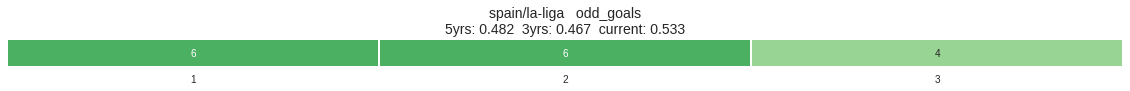

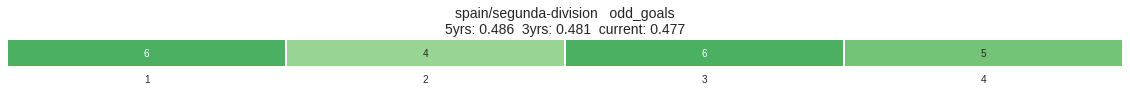

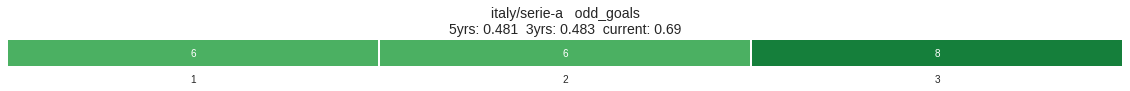

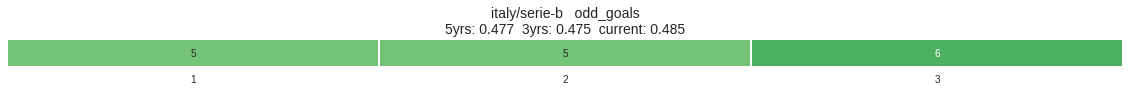

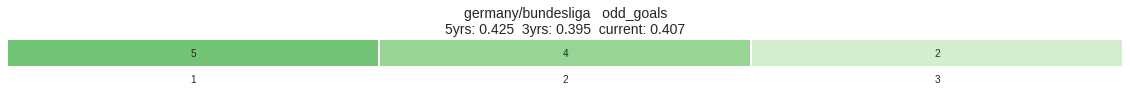

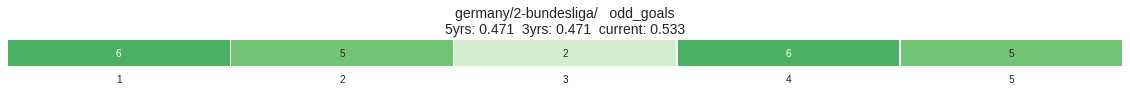

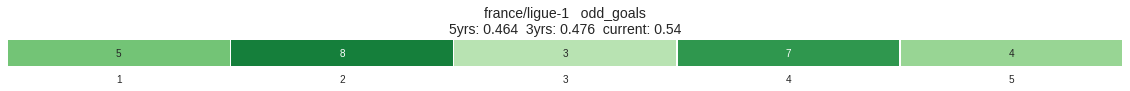

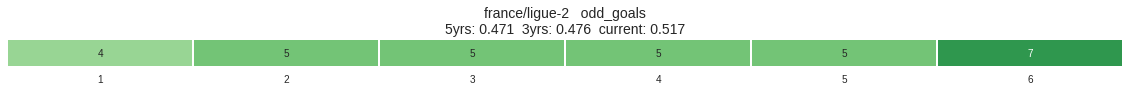

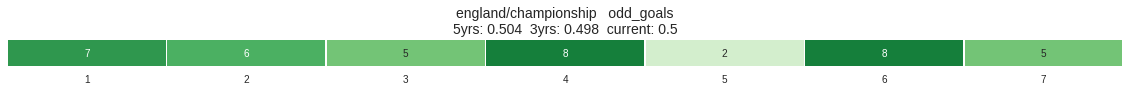

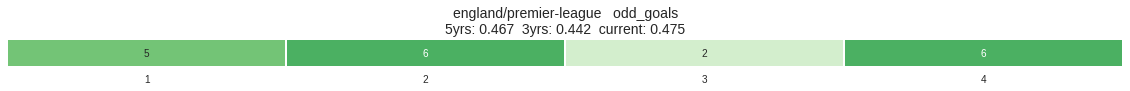

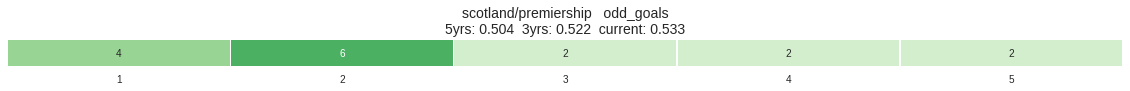

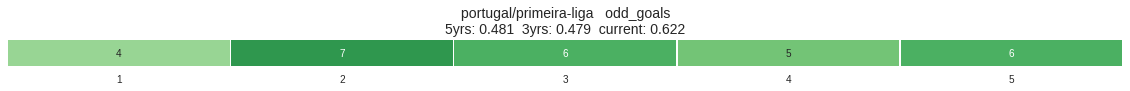

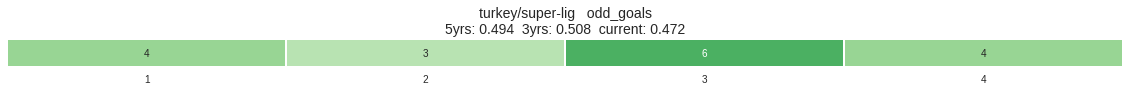

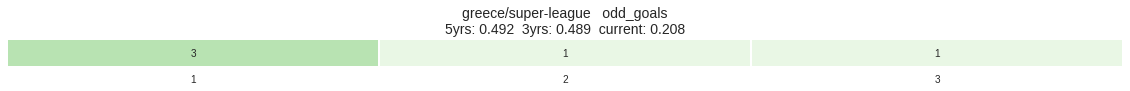

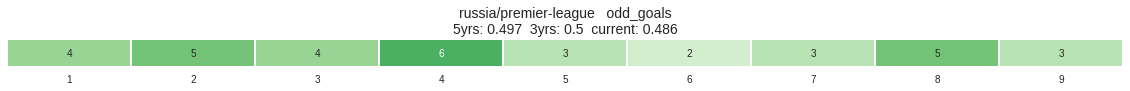

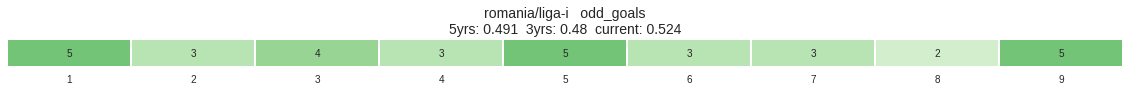

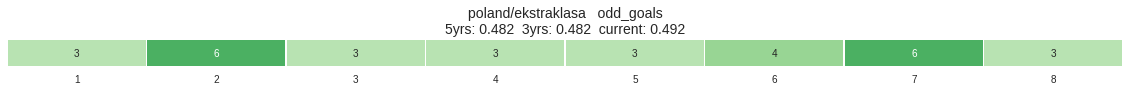

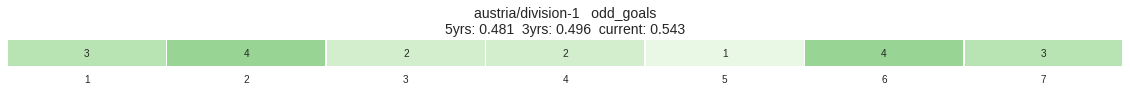

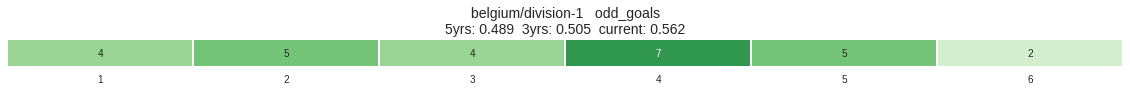

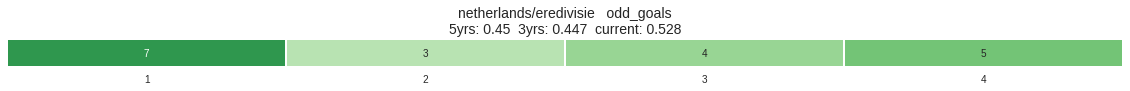

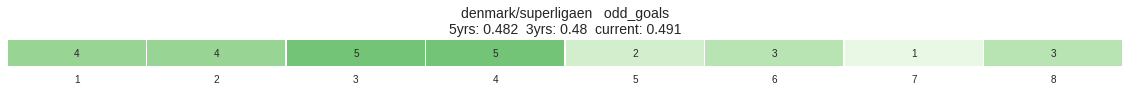

In [33]:
# per selection
selections = ['odd_goals'] 
for selection in selections:
    history = get_history_df(selection)
    for league in teams.keys():
        frequency = get_selection_frequency(league)
        probability_report = get_report(league, selection)
        plot_selection(frequency)

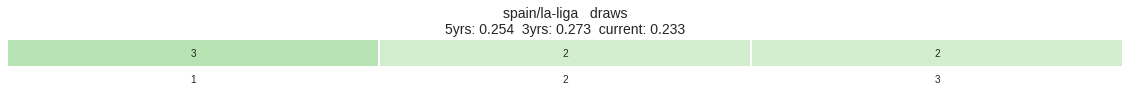

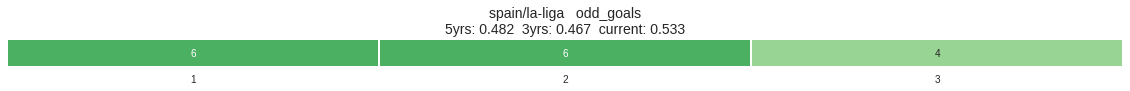

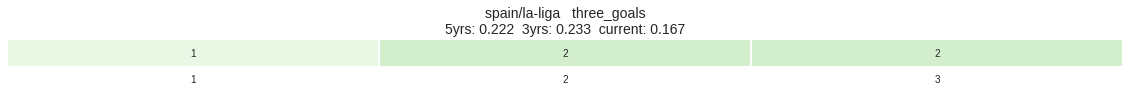

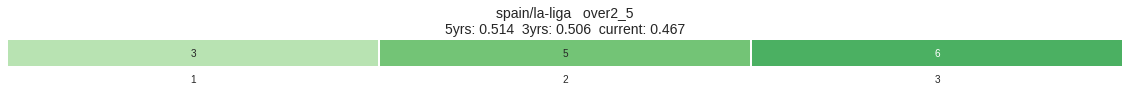

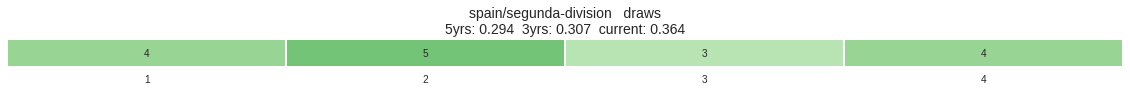

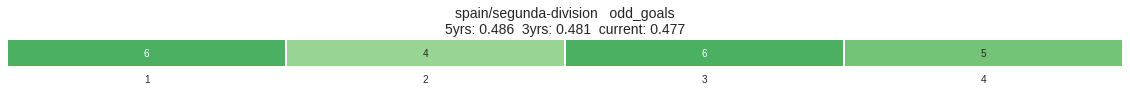

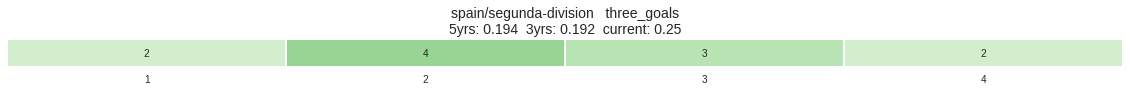

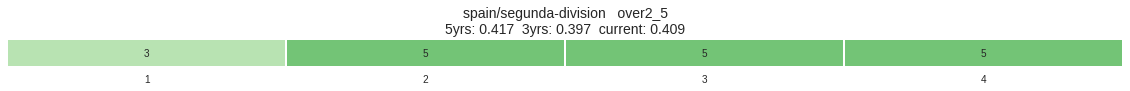

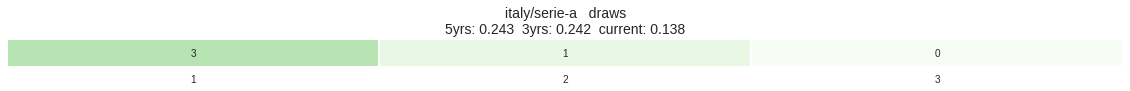

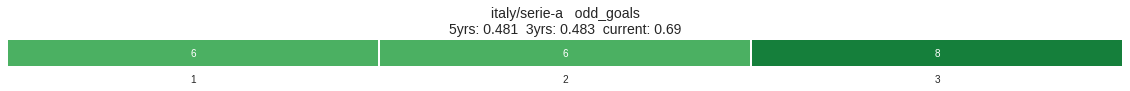

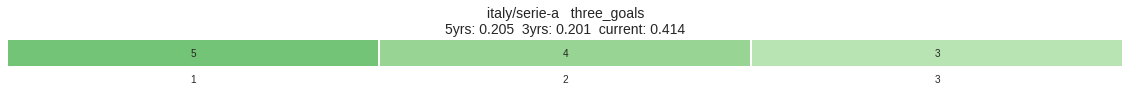

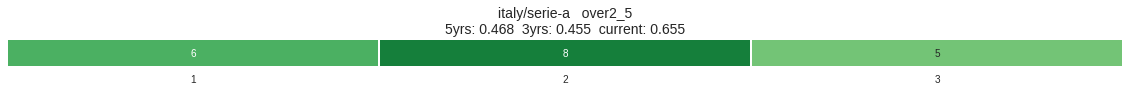

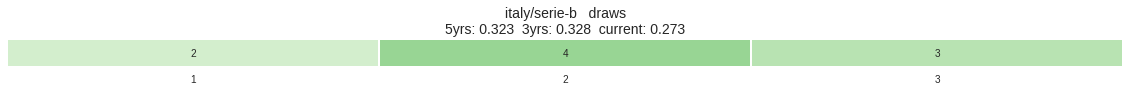

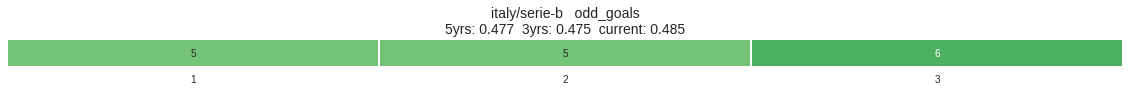

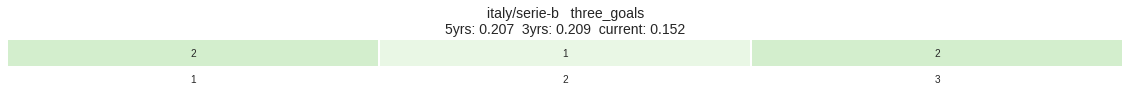

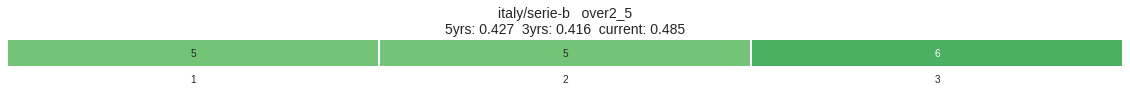

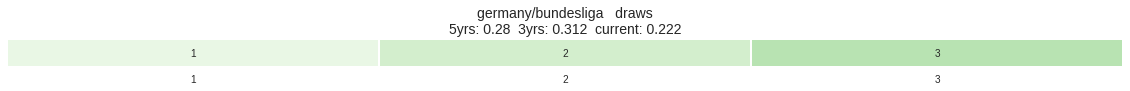

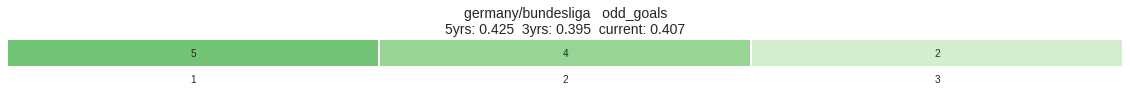

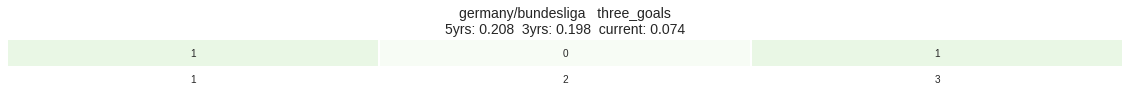

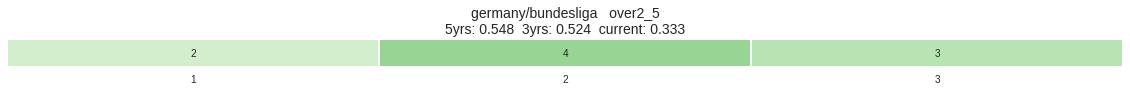

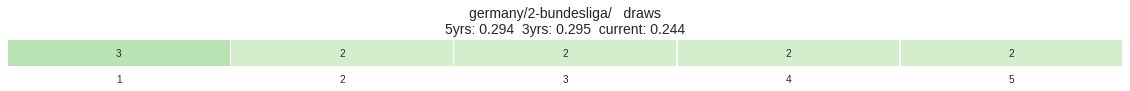

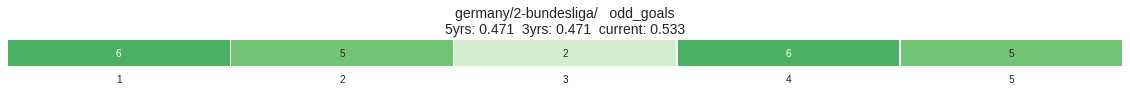

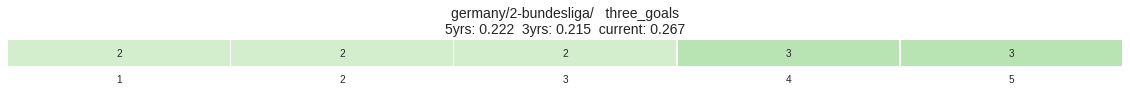

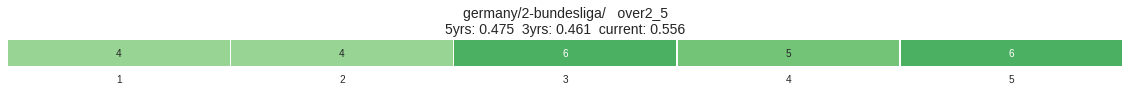

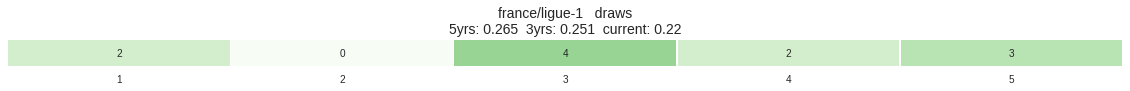

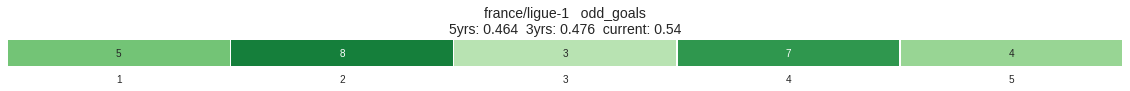

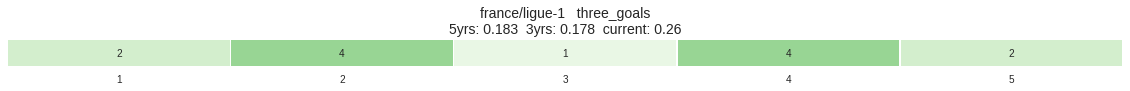

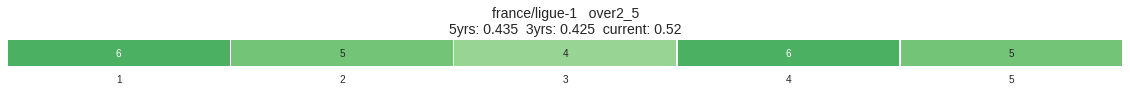

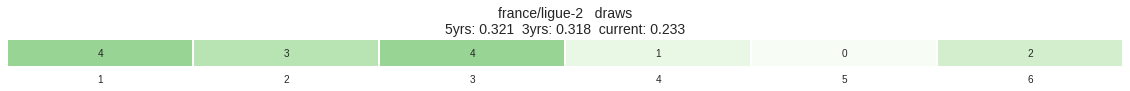

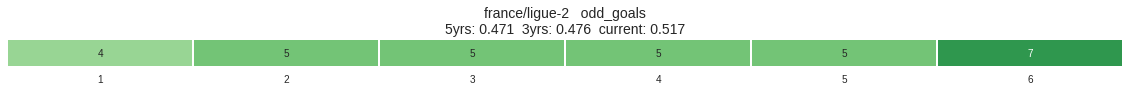

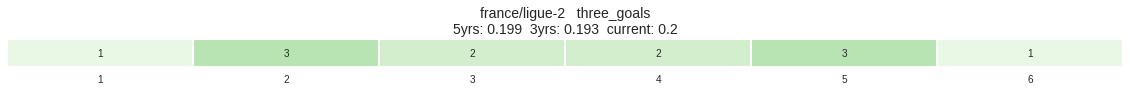

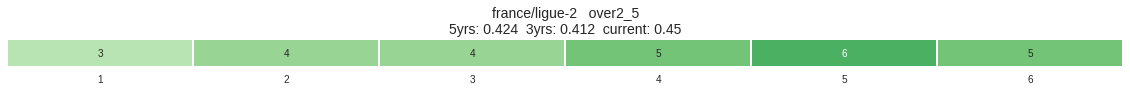

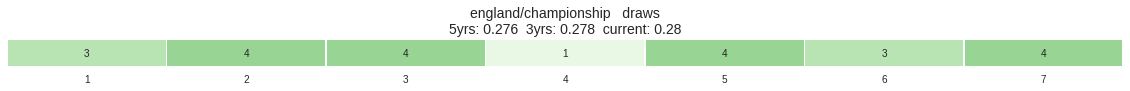

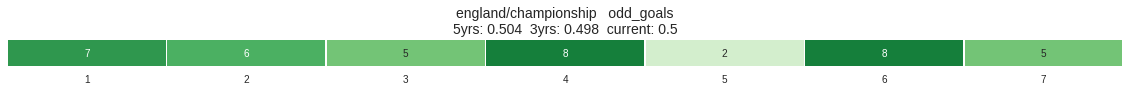

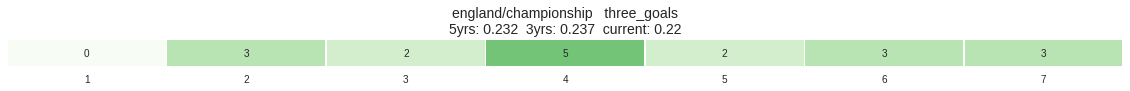

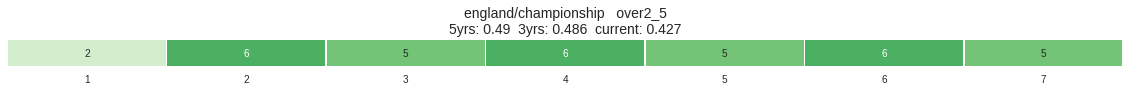

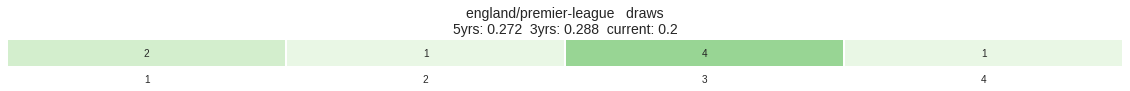

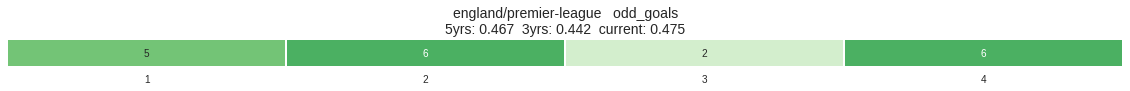

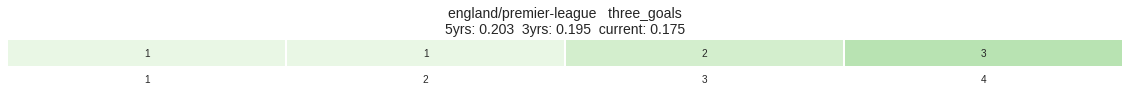

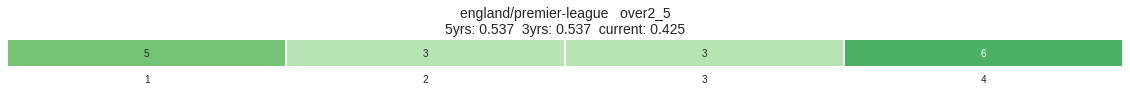

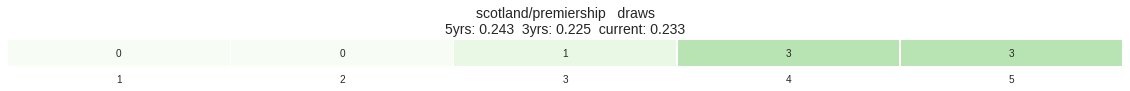

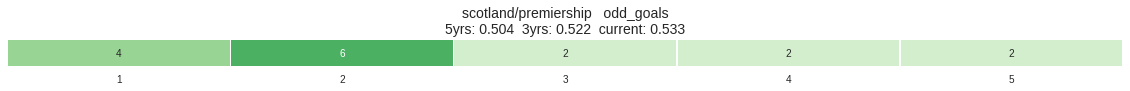

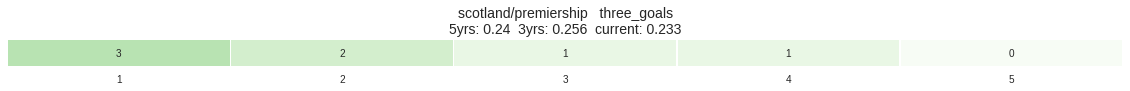

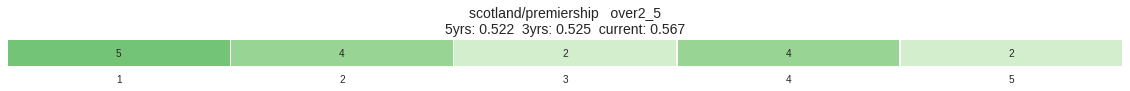

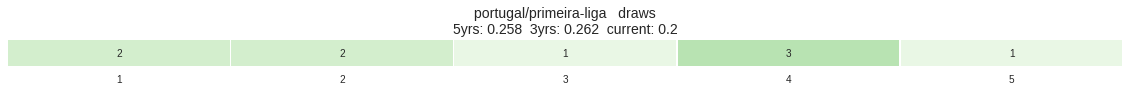

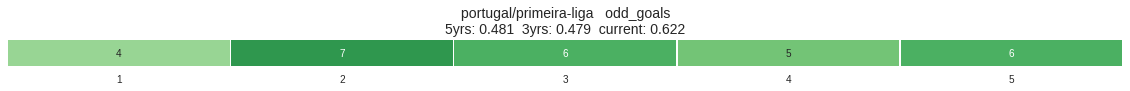

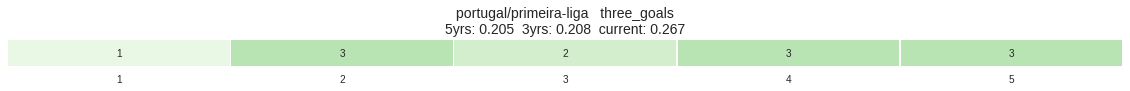

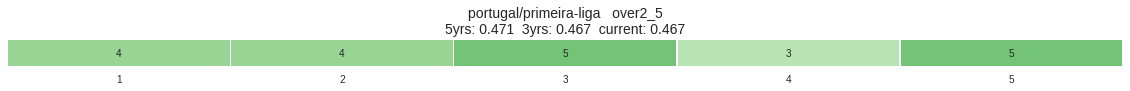

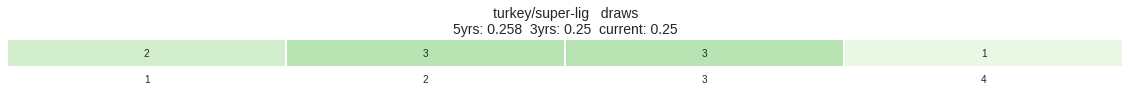

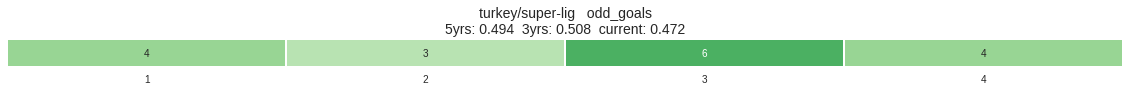

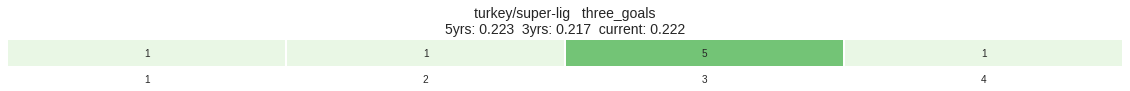

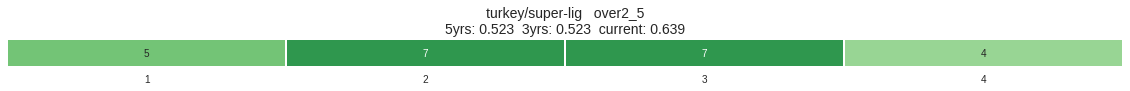

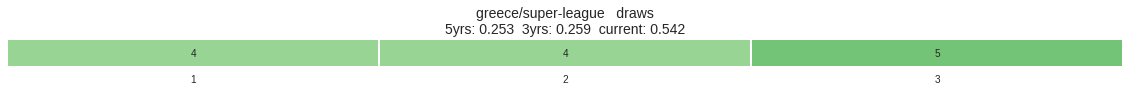

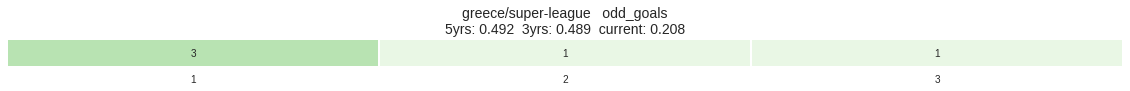

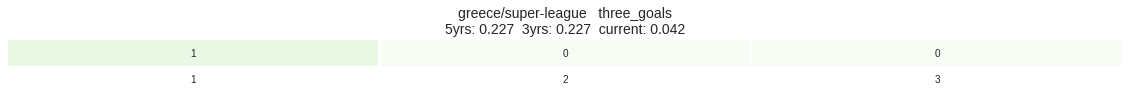

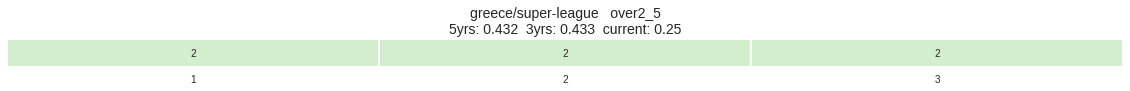

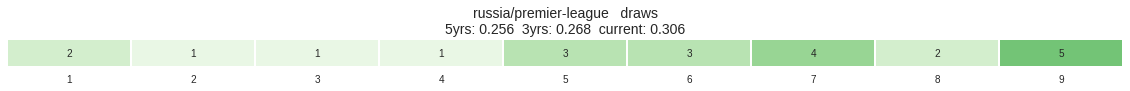

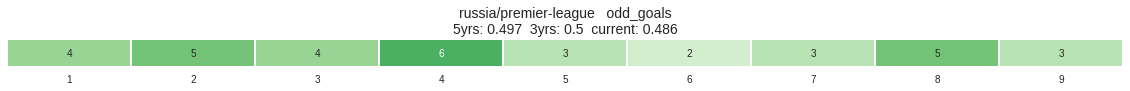

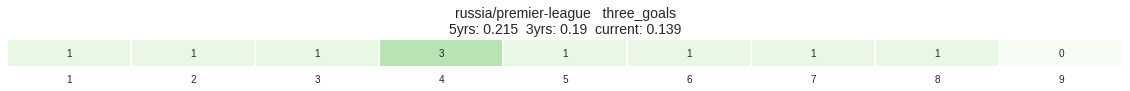

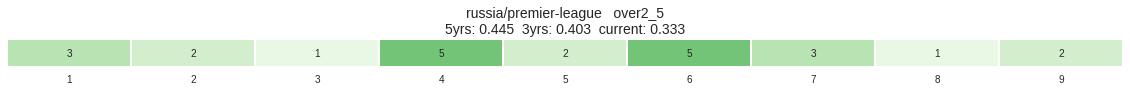

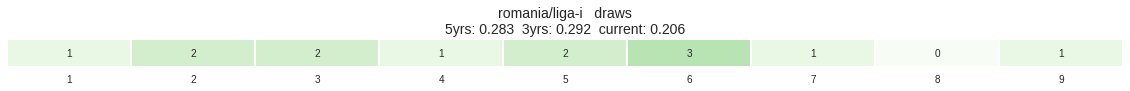

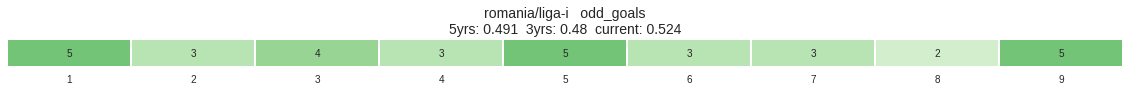

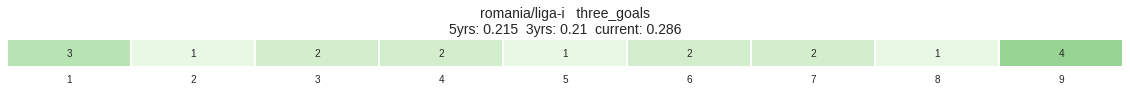

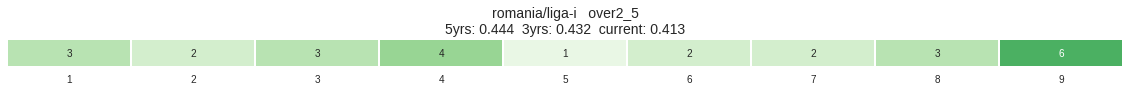

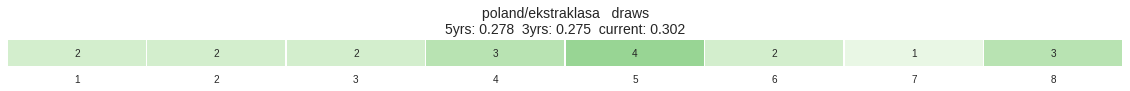

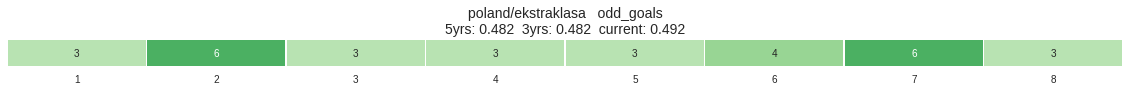

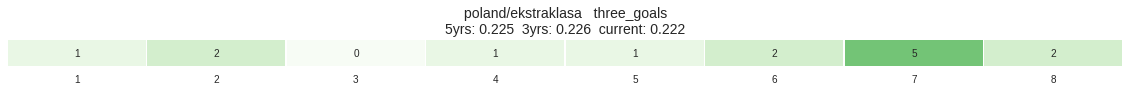

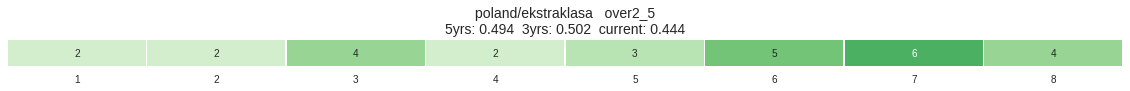

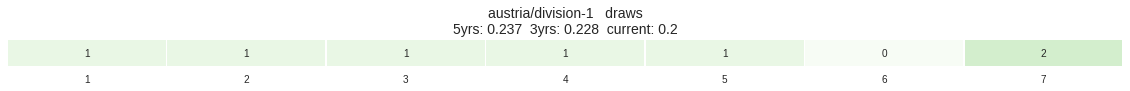

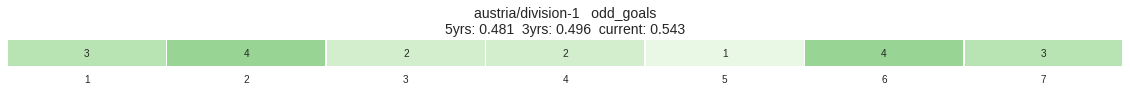

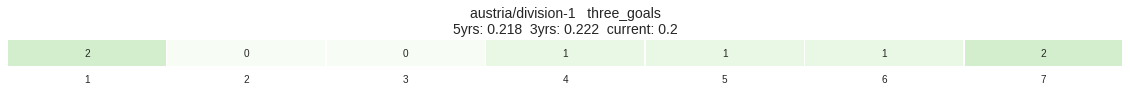

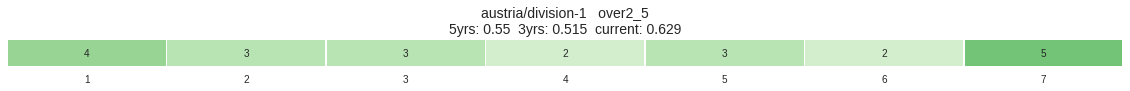

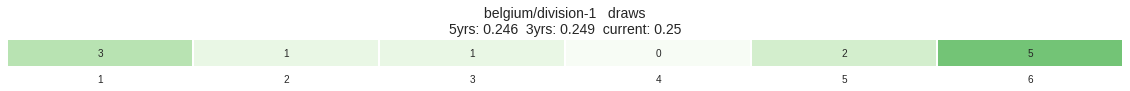

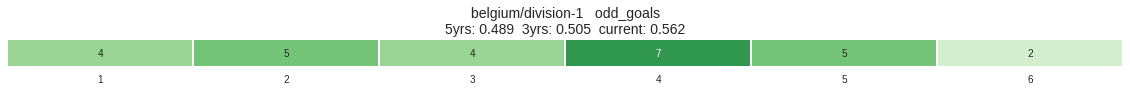

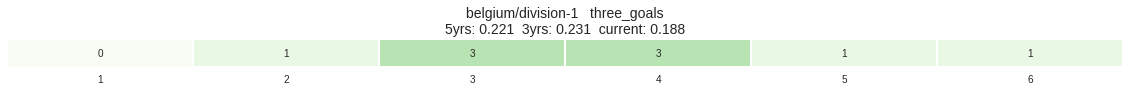

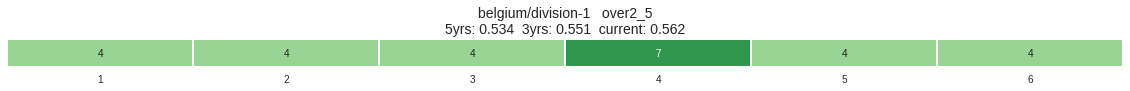

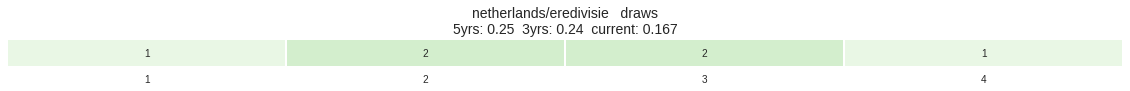

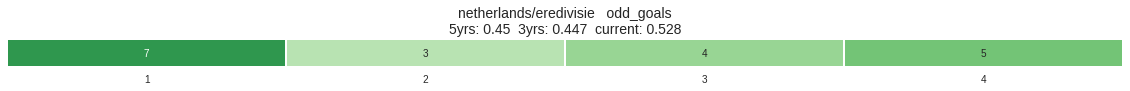

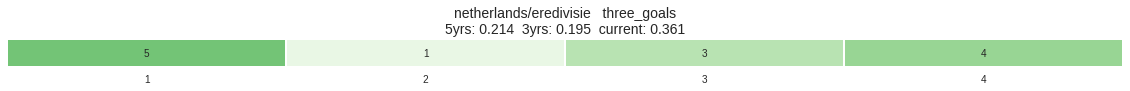

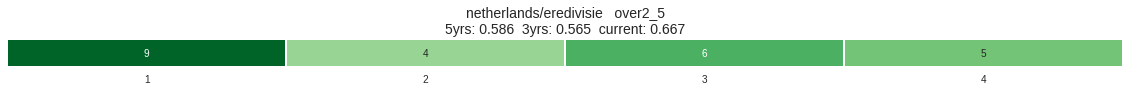

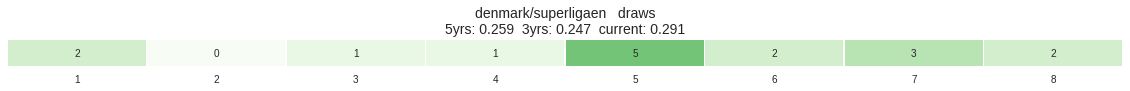

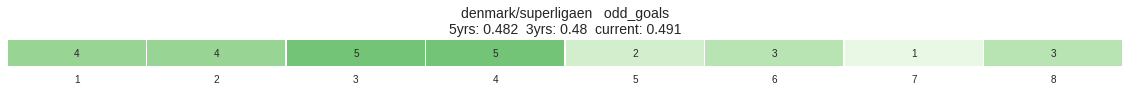

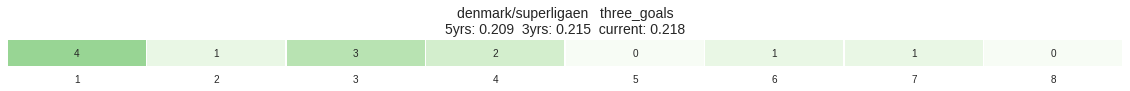

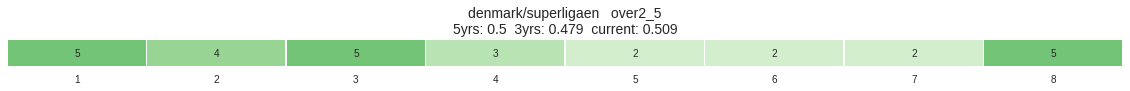

In [34]:
# per country

selections = ['draws', 'odd_goals', 'three_goals', 'over2_5']
for league in teams.keys():
    for selection in selections:
        history = get_history_df(selection)
        frequency = get_selection_frequency(league)
        probability_report = get_report(league, selection)
        plot_selection(frequency)

In [1]:
# markets to bet on weekend 16.09 - 17.09

# even goals: serie-a, portugal
# odd goals: greece
# draw: italy
# three goals: germany, greece